In [1]:
import numpy as onp
import jax
import jax.numpy as np

from jax import lax, random
from jax.api import grad, jit, vmap
from jax.config import config
from jax.experimental import optimizers

config.update('jax_enable_x64', True)

from functools import partial
from jax import random

from neural_tangents import stax

# Attacking
from jax.experimental.stax import logsoftmax
from cleverhans.utils import clip_eta, one_hot

# Plotting
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils import *
sns.set_style(style='white')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

"""
diag_reg:
    a scalar representing the strength of the diagonal regularization for
    `k_train_train`, i.e. computing `k_train_train + diag_reg * I` during
    Cholesky factorization or eigendecomposition.
"""
diag_reg = 1e-5
batch_size = 30

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# data

In [5]:
x_train_all, y_train_all, x_test_all, y_test_all = tuple(onp.array(x) for x in get_dataset('cifar10', None, None, 
                                                                                  do_flatten_and_normalize=False))
class_num = 10

In [6]:
# shuffle
seed = 0
x_train_all, y_train_all = shaffle(x_train_all, y_train_all, seed)

In [7]:
# down sample

train_size = 4096
x_train = x_train_all[:train_size]
y_train = y_train_all[:train_size]

test_size = 512
x_test = x_test_all[:test_size]
y_test = y_test_all[:test_size]

# shape = (x_train.shape[0], 32, 32, 3)

In [8]:
device_id = jax.devices()[0]

In [9]:
# move to gpu

x_train = jax.device_put(x_train, device=device_id)
y_train = jax.device_put(y_train, device=device_id)

x_test = jax.device_put(x_test, device=device_id)
y_test = jax.device_put(y_test, device=device_id)

# model

In [10]:
def accuracy(mean, ys):
    return np.mean(np.argmax(mean, axis=-1) == np.argmax(ys, axis=-1))

In [11]:
def DenseBlock(neurons, W_std, b_std):
    return stax.serial(stax.Dense(neurons, W_std, b_std), 
                       stax.Erf())

def DenseGroup(n, neurons, W_std, b_std):
    blocks = []
    for _ in range(n):
        blocks += [DenseBlock(neurons, W_std, b_std)]
    # final layer    
    blocks += [stax.Dense(class_num, W_std, b_std)]
    return stax.serial(*blocks)

In [12]:
b = 0.18
W = 1.76

phase_list = 'Critical'

layer = 3
num_classes = 10

key = random.PRNGKey(0)

b_std = np.sqrt(b)
W_std = np.sqrt(W)

init_fn, apply_fn, kernel_fn = stax.serial(DenseGroup(layer, 1024, W_std, b_std))
    
# Inference with a single infinite width / linearized network
# kernel_fn(x_train, x_test, 'ntk' or 'nngp')
kernel_fn = jit(kernel_fn, static_argnums=(2,))

In [13]:
def model_fn(kernel_fn, obj_fn, x_train=None, x_test=None, fx_train_0=0., fx_test_0=0., t=None):
    # Kernel
    ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
    
    if obj_fn == 'train':
        return ntk_train_train
    elif obj_fn == 'test':
        ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
        # Prediction
        predict_fn = nt.predict.gradient_descent_mse(ntk_train_train, y_train, diag_reg=diag_reg) # no convariance
        return predict_fn(t, fx_train_0, fx_test_0, ntk_test_train) # fx_train_0, fx_test_0 = (0, 0) for infinite width
    else:
        raise ValueError("Objective function must be either train(ntk_train_train) or test(predict_fn)")

In [14]:
def inv(k):
        #inverse with diag_reg
        return np.linalg.inv(k + diag_reg * np.eye(k.shape[0]))

ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
ntk_train_train_inv = inv(ntk_train_train)

# loss

In [15]:
@jit
def l2_loss_v1(logits, labels, weighting=1):
    """
    Tensorflow version of L2 loss (without sqrt)
    """
    return np.sum(((logits - labels)**2) * weighting) / 2
    
@jit
def l2_loss_v2(logits, lables):
    """
    Normal L2 loss
    """
    return np.linalg.norm(logits - labels)

@jit
def cross_entropy_loss(logits, lables):
    return -np.sum(logsoftmax(logits) * lables)
    
@jit
def mse_loss(logits, lables):
    return 0.5 * np.mean((logits - lables) ** 2)

In [16]:
def test_loss_adv_matrix(x_train, x_test, kernel_fn, c, t=None, 
                         ntk_train_train_inv=ntk_train_train_inv):
    # Kernel -> matrix of constant c
    assert type(c) == int
    
    ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
    # Θ(test, train)Θ(train, train)^-1
    # def inv(k):
        #inverse with diag_reg
    #    return np.linalg.inv(k + diag_reg * np.eye(k.shape[0]))
    
    mean_predictor = np.einsum('ij,jk->ik', ntk_test_train, ntk_train_train_inv)
    
    # Loss
    loss = - l2_loss_v1(mean_predictor, np.ones_like(mean_predictor)*c)
    return loss

# grad for x_test
test_grads_fn = jit(grad(test_loss_adv_matrix, argnums=1), static_argnums=(0, 2))
test_c_grads_fn = jit(grad(test_loss_adv_matrix, argnums=3), static_argnums=(0, 2))

In [17]:
def test_loss_adv_col(x_train, x_test, kernel_fn, c, t=None,
                     ntk_train_train_inv=ntk_train_train_inv):
    """
    Kernel -> matrix with constant cols
    
    c is a vector of constant. c.shape should be (1, test_size)
    
    """ 
    assert c.shape[0] == 1
    assert len(c.shape) == 2
    
    # ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
    ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
    
    # Θ(test, train)Θ(train, train)^-1
    # inverse with diag_reg
    # def inv(k):
    #    return np.linalg.inv(k + diag_reg * np.eye(k.shape[0]))
    
    mean_predictor = np.einsum('ij,jk->ik', ntk_test_train, ntk_train_train_inv)
    
    # Loss
    loss = - l2_loss_v1(mean_predictor, np.ones_like(mean_predictor)*c.T)
    return loss

# grad for x_test
test_col_wise_grads_fn = jit(grad(test_loss_adv_col, argnums=1), static_argnums=(2,))
test_col_wise_c_grads_fn = jit(grad(test_loss_adv_col, argnums=3), static_argnums=(2,))

In [18]:
def test_loss_adv_row(x_train, x_test, kernel_fn, c, t=None,
                     ntk_train_train_inv=ntk_train_train_inv):
    """
    Kernel -> matrix with constant rows
    
    c is a vector of constant. c.shape should be (1, train_size)
    
    """ 
    assert c.shape[0] == 1
    assert len(c.shape) == 2
    
    # ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
    ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
    
    # Θ(test, train)Θ(train, train)^-1
    # inverse with diag_reg
    # def inv(k):
    #    return np.linalg.inv(k + diag_reg * np.eye(k.shape[0]))
    
    mean_predictor = np.einsum('ij,jk->ik', ntk_test_train, ntk_train_train_inv)
    
    # Loss
    loss = - l2_loss_v1(mean_predictor, np.ones_like(mean_predictor)*c)
    return loss

# grad for x_test
test_row_wise_grads_fn = jit(grad(test_loss_adv_row, argnums=1), static_argnums=(2,))
test_row_wise_c_grads_fn = jit(grad(test_loss_adv_row, argnums=3), static_argnums=(2,))

In [19]:
# a = np.array([
#     [1, 1, 1],
#     [1, 1, 1]
# ], dtype=np.float32)

# b_col = np.array([
#     [0.1, 10.]
# ], dtype=np.float32)

# b_row = np.array([
#     [0.1, 10., -1]
# ], dtype=np.float32)

# print(a*b_col.T)
# print()
# print(a*b_row)

# a.shape = (2, 3) test_size=2, train_size=3
# col broadcast -> b.shape = (1, 2), a*b.T
# row broadcast -> b.shape = (1, 3), a*b

In [20]:
# a.shape = (test, train)
# col broadcast -> b.shape = (1, test), a*b.T
# row broadcast -> b.shape = (1, train), a*b

In [21]:
def fast_gradient_method(model_fn, kernel_fn, obj_fn, grads_fn, grads_c_fn=None, x_train=None, y_train=None, x_test=None, 
                         y=None, t=None, c=None, update_c=False, loss_weighting=None, phase=None, 
                         fx_train_0=0., fx_test_0=0., eps=0.3, norm=np.inf, clip_min=None, clip_max=None, targeted=False):
    """
    JAX implementation of the Fast Gradient Method.
    :param model_fn: a callable that takes an input tensor and returns the model logits.
    :param x: input tensor.
    :param eps: epsilon (input variation parameter); see https://arxiv.org/abs/1412.6572.
    :param norm: Order of the norm (mimics NumPy). Possible values: np.inf or 2.
    :param clip_min: (optional) float. Minimum float value for adversarial example components.
    :param clip_max: (optional) float. Maximum float value for adversarial example components.
    :param y: (optional) Tensor with one-hot true labels. If targeted is true, then provide the
            target one-hot label. Otherwise, only provide this parameter if you'd like to use true
            labels when crafting adversarial samples. Otherwise, model predictions are used
            as labels to avoid the "label leaking" effect (explained in this paper:
            https://arxiv.org/abs/1611.01236). Default is None. This argument does not have
            to be a binary one-hot label (e.g., [0, 1, 0, 0]), it can be floating points values
            that sum up to 1 (e.g., [0.05, 0.85, 0.05, 0.05]).
    :param targeted: (optional) bool. Is the attack targeted or untargeted?
            Untargeted, the default, will try to make the label incorrect.
            Targeted will instead try to move in the direction of being more like y.
    :return: a tensor for the adversarial example
    """
    if norm not in [np.inf, 2]:
        raise ValueError("Norm order must be either np.inf or 2.")
        
    x = x_test
    # Obtain y
    # if obj_fn == 'test':
    #   if y is None:
    #        # Using model predictions as ground truth to avoid label leaking
    #        x_labels = np.argmax(model_fn(kernel_fn, 'test', x_train, x_test, fx_train_0, fx_test_0)[1], 1)
    #        y = one_hot(x_labels, 10)
        
    # Obj - Θ(test, train)Θ(train, train)^-1
    # test independent
    if obj_fn == 'test_col':
        grads = 0
        grads_c = 0
        grads = grads_fn(x_train, x_test, kernel_fn, c)
        if update_c is True:
            grads_c += grads_c_fn(x_train, x_test, kernel_fn, c)
        # for i in range(int(len(x_test)/batch_size)):
        #    grads += grads_fn(x_train, x_test, kernel_fn, c)
        #    if update_c is True:
        #        grads_c += grads_c_fn(x_train, x_test, kernel_fn, c)
                
        grads_c = 1e-5 * np.sign(grads_c) # grads_c = 5e-2 * np.sign(grads_c)
        
        
    # Obj - Θ(test, train)Θ(train, train)^-1 y_train
    else:
        raise ValueError("Objective function must be either train(ntk_train_train) or test(predict_fn)")

    axis = list(range(1, len(grads.shape)))
    eps_div = 1e-12
    
    if norm == np.inf:
        perturbation = eps * np.sign(grads)
    elif norm == 1:
        raise NotImplementedError("L_1 norm has not been implemented yet.")
    elif norm == 2:
        square = np.maximum(eps_div, np.sum(np.square(grads), axis=axis, keepdims=True))
        perturbation = grads / np.sqrt(square)
    
    # TODO
    adv_x = x + perturbation
    
    # If clipping is needed, reset all values outside of [clip_min, clip_max]
    if (clip_min is not None) or (clip_max is not None):
        # We don't currently support one-sided clipping
        assert clip_min is not None and clip_max is not None
        adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)
    
    if obj_fn == 'test_c':
        c += grads_c
        
        return adv_x, c
    
    return adv_x, c

In [22]:
def projected_gradient_descent(model_fn, kernel_fn, obj_fn, grads_fn, grads_c_fn=None, x_train=None, y_train=None,
                               x_test=None, y=None, t=None, c=None, update_c=None, loss_weighting=None, 
                               phase=None, fx_train_0=0., fx_test_0=0., eps=0.3, eps_iter=0.03, nb_iter=10, norm=np.inf, 
                               clip_min=None, clip_max=None, targeted=False, rand_init=None, rand_minmax=0.3):
    """
    This class implements either the Basic Iterative Method
    (Kurakin et al. 2016) when rand_init is set to 0. or the
    Madry et al. (2017) method when rand_minmax is larger than 0.
    Paper link (Kurakin et al. 2016): https://arxiv.org/pdf/1607.02533.pdf
    Paper link (Madry et al. 2017): https://arxiv.org/pdf/1706.06083.pdf
    :param model_fn: a callable that takes an input tensor and returns the model logits.
    :param x: input tensor.
    :param eps: epsilon (input variation parameter); see https://arxiv.org/abs/1412.6572.
    :param eps_iter: step size for each attack iteration
    :param nb_iter: Number of attack iterations.
    :param norm: Order of the norm (mimics NumPy). Possible values: np.inf or 2.
    :param clip_min: (optional) float. Minimum float value for adversarial example components.
    :param clip_max: (optional) float. Maximum float value for adversarial example components.
    :param y: (optional) Tensor with true labels. If targeted is true, then provide the
            target label. Otherwise, only provide this parameter if you'd like to use true
            labels when crafting adversarial samples. Otherwise, model predictions are used
            as labels to avoid the "label leaking" effect (explained in this paper:
            https://arxiv.org/abs/1611.01236). Default is None.
    :param targeted: (optional) bool. Is the attack targeted or untargeted?
            Untargeted, the default, will try to make the label incorrect.
            Targeted will instead try to move in the direction of being more like y.
    :return: a tensor for the adversarial example
    """

    assert eps_iter <= eps, (eps_iter, eps)
    if norm == 1:
        raise NotImplementedError("It's not clear that FGM is a good inner loop"
                                  " step for PGD when norm=1, because norm=1 FGM "
                                  " changes only one pixel at a time. We need "
                                  " to rigorously test a strong norm=1 PGD "
                                  "before enabling this feature.")
    if norm not in [np.inf, 2]:
        raise ValueError("Norm order must be either np.inf or 2.")
        
    x = x_test
    
    # Initialize loop variables
    if rand_init:
        rand_minmax = eps
        eta = random.uniform(new_key, x.shape, minval=-rand_minmax, maxval=rand_minmax)
    else:
        eta = np.zeros_like(x)

    # Clip eta
    eta = clip_eta(eta, norm, eps)
    adv_x = x + eta
    if clip_min is not None or clip_max is not None:
        adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)
        
    for i in range(nb_iter):
        if update_c is not None and (i+1) % update_c == 0:
            adv_x = fast_gradient_method(model_fn, kernel_fn, obj_fn, grads_fn, grads_c_fn, x_train, y_train, adv_x, 
                                         y, t, c, True, loss_weighting, phase, fx_train_0, fx_test_0, eps_iter, norm, 
                                         clip_min, clip_max, targeted)
        else:
            adv_x = fast_gradient_method(model_fn, kernel_fn, obj_fn, grads_fn, grads_c_fn, x_train, y_train, adv_x, 
                                         y, t, c, False, loss_weighting, phase, fx_train_0, fx_test_0, eps_iter, norm, 
                                         clip_min, clip_max, targeted)
        
        if obj_fn == 'test_col' or obj_fn == 'test_row':
            adv_x, c = adv_x

        # Clipping perturbation eta to norm norm ball
        eta = adv_x - x
        eta = clip_eta(eta, norm, eps)
        adv_x = x + eta

        # Redo the clipping.
        # FGM already did it, but subtracting and re-adding eta can add some
        # small numerical error.
        if clip_min is not None or clip_max is not None:
            adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)
    
    if obj_fn == 'test_col' or obj_fn == 'test_row':
        return adv_x, c
    
    return adv_x

# Attack Hyperparameters

In [23]:
attack_type = ["Clean", "FGSM", "PGD-10", "PGD-100"]

####### MNIST #######
# eps = 0.3
# eps_iter_10 = 0.04
# eps_iter_100 = 0.004
####### MNIST #######

####### CIFAR #######
eps = 16/255
eps_iter_10 = (eps/10)*1.1
eps_iter_100 = (eps/100)*1.1
####### CIFAR #######

# val_size = 1200

# x_train_all is on host device
# x_val = x_train_all[train_size:train_size+val_size]
# y_val = y_train_all[train_size:train_size+val_size]

# to gpu
# x_val = np.asarray(x_val)
# y_val = np.asarray(y_val)

# Variance

In [24]:
def mean_predictor(x_train, x_test, kernel_fn, c=None, row=False, col=False, get_sample=False,
                   ntk_train_train_inv=ntk_train_train_inv):
    """
    return Θ(test, train)Θ(train, train)^-1 and 
    || # Θ(test, train)Θ(train, train)^-1 - target ||
    
    """
    if not row and not col:
        raise ValueError("at least one of row or col should be true")
        
    # Kernel
    ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
    
    # Θ(test, train)Θ(train, train)^-1
    mean_predictor = np.einsum('ij,jk->ik', ntk_test_train, ntk_train_train_inv)
    loss = 0.0
    
    if c is None:
        if row ^ col:
            if row:
                c = np.mean(mean_predictor, axis=0)
                c = np.reshape(c, (1, -1))
                # print(c.shape)
                # print(mean_predictor.shape)
                loss = l2_loss_v1(mean_predictor, np.ones_like(mean_predictor)*c)
            elif col:
                c = np.mean(mean_predictor, axis=1)
                c = np.reshape(c, (1, -1))
                # print(c.shape)
                # print(mean_predictor.shape)
                loss = l2_loss_v1(mean_predictor, np.ones_like(mean_predictor)*c.T)
        else:
            raise ValueError("row xor col not true")
            
    if get_sample:
        return c
    
    return loss, mean_predictor

In [25]:
def evaluate(x_train, x_test, model_fn, kernel_fn, t=None, c=0, attack_type=None):
    y_train_predict, y_test_predict = model_fn(kernel_fn, 'test', x_train, x_test, t=t)
    acc = accuracy(y_test_predict, y_test)
    print("Robustness({:s}): {:.2f}".format(attack_type, acc))
    
    return acc

In [26]:
def get_matrix(adv_x, x_train=x_train, kernel_fn=kernel_fn):
    ntk_test_train = kernel_fn(adv_x, x_train, 'ntk')
    matrix = np.einsum('ij,jk->ik', ntk_test_train, ntk_train_train_inv)
    return matrix

# train list gen

In [27]:
t = None
d = 'col'

In [28]:
evaluate(x_train, x_test, model_fn=model_fn, kernel_fn=kernel_fn, t=t, c=0, attack_type='Clean')

Robustness(Clean): 0.40


DeviceArray(0.3984375, dtype=float64)

In [29]:
m_clean = get_matrix(x_test)
np.mean(np.std(m_clean, axis=0))

DeviceArray(0.01187553, dtype=float64)

In [30]:
if d == 'col':
    c_sample = mean_predictor(x_train, x_test, kernel_fn, col=True, get_sample=True)
elif d == 'row':
    c_sample = mean_predictor(x_train, x_test, kernel_fn, row=True, get_sample=True)

In [31]:
c = c_sample.reshape((1, -1))

In [32]:
# FGSM
adv_x_FGSM, c = fast_gradient_method(model_fn=model_fn, kernel_fn=kernel_fn, obj_fn='test_col', 
                                     grads_fn=test_col_wise_grads_fn, grads_c_fn=test_col_wise_c_grads_fn,
                                     x_train=x_train, y_train=y_train, x_test=x_test, y=y_test, t=t, c=c,
                                     eps=eps, clip_min=0, clip_max=1)

evaluate(x_train, adv_x_FGSM, model_fn=model_fn, kernel_fn=kernel_fn, t=t, c=c, attack_type='FGSM')

Robustness(FGSM): 0.27


DeviceArray(0.26757812, dtype=float64)

In [33]:
m_FGSM = get_matrix(adv_x_FGSM)
np.mean(np.std(m_FGSM, axis=0))

DeviceArray(0.01194893, dtype=float64)

In [34]:
# PGD 10
key, new_key = random.split(key)
c = c_sample.reshape((1, -1))
adv_x_PGD_10 , c = projected_gradient_descent(model_fn=model_fn, kernel_fn=kernel_fn, obj_fn='test_col', 
                                              grads_fn=test_col_wise_grads_fn, grads_c_fn=test_col_wise_c_grads_fn,
                                              x_train=x_train, y_train=y_train, x_test=x_test, y=y_test, t=t, c=c, update_c=3, 
                                              eps=eps, eps_iter=eps_iter_10, nb_iter=10, 
                                              clip_min=0, clip_max=1, rand_init=None, rand_minmax=eps)

evaluate(x_train, adv_x_PGD_10, model_fn=model_fn, kernel_fn=kernel_fn, t=t, c=c, attack_type='PGD-10')

Robustness(PGD-10): 0.43


DeviceArray(0.42578125, dtype=float64)

In [35]:
m_PGD_10 = get_matrix(adv_x_PGD_10)
np.mean(np.std(m_PGD_10, axis=0))

DeviceArray(0.0087033, dtype=float64)

In [36]:
# PGD 100
key, new_key = random.split(key)
c = c_sample.reshape((1, -1))
adv_x_PGD_100, c = projected_gradient_descent(model_fn=model_fn, kernel_fn=kernel_fn, obj_fn='test_col', 
                                              grads_fn=test_col_wise_grads_fn, grads_c_fn=test_col_wise_c_grads_fn,
                                              x_train=x_train, y_train=y_train, x_test=x_test, y=y_test, t=t, c=c, update_c=3, 
                                              eps=eps, eps_iter=eps_iter_100, nb_iter=100, 
                                              clip_min=0, clip_max=1, rand_init=None, rand_minmax=eps)

evaluate(x_train, adv_x_PGD_100, model_fn=model_fn, kernel_fn=kernel_fn, t=t, c=c, attack_type='PGD-100')

Robustness(PGD-100): 0.43


DeviceArray(0.42773438, dtype=float64)

In [37]:
m_PGD_100 = get_matrix(adv_x_PGD_100)
np.mean(np.std(m_PGD_100, axis=0))

DeviceArray(0.00803576, dtype=float64)

In [38]:
# PGD 1000
key, new_key = random.split(key)
c = c_sample.reshape((1, -1))
adv_x_PGD_1000, c = projected_gradient_descent(model_fn=model_fn, kernel_fn=kernel_fn, obj_fn='test_col', 
                                              grads_fn=test_col_wise_grads_fn, grads_c_fn=test_col_wise_c_grads_fn,
                                              x_train=x_train, y_train=y_train, x_test=x_test, y=y_test, t=t, c=c, update_c=3, 
                                              eps=eps, eps_iter=eps_iter_100, nb_iter=1000, 
                                              clip_min=0, clip_max=1, rand_init=None, rand_minmax=eps)

evaluate(x_train, adv_x_PGD_1000, model_fn=model_fn, kernel_fn=kernel_fn, t=t, c=c, attack_type='PGD-1000')

Robustness(PGD-1000): 0.42


DeviceArray(0.42382812, dtype=float64)

In [40]:
m_PGD_1000 = get_matrix(adv_x_PGD_1000)
np.mean(np.std(m_PGD_1000, axis=0))

DeviceArray(0.00789338, dtype=float64)

# transfer

In [41]:
b = 0.18
W = 1.76

clean_acc    = []
fgsm_acc     = []
pgd_10_acc   = []
pgd_100_acc  = []
pgd_1000_acc = []

for layer in range(50):
    print("***********")
    print("layer: ", layer)
    num_classes = 10
    key = random.PRNGKey(0)

    b_std = np.sqrt(b)
    W_std = np.sqrt(W)

    init_fn, apply_fn, kernel_fn_trans = stax.serial(DenseGroup(layer, 1024, W_std, b_std))
    kernel_fn_trans = jit(kernel_fn_trans, static_argnums=(2,))

    ntk_train_train_trans = kernel_fn_trans(x_train, x_train, 'ntk')
    ntk_train_train_inv_trans = inv(ntk_train_train_trans)

    clean_acc.append(evaluate(x_train, x_test, model_fn=model_fn, kernel_fn=kernel_fn_trans, t=t, c=0, attack_type='Clean'))
    fgsm_acc.append(evaluate(x_train, adv_x_FGSM, model_fn=model_fn, kernel_fn=kernel_fn_trans, t=t, c=0, attack_type='FGSM'))
    pgd_10_acc.append(evaluate(x_train, adv_x_PGD_10, model_fn=model_fn, kernel_fn=kernel_fn_trans, t=t, c=0, attack_type='PGD-10'))
    pgd_100_acc.append(evaluate(x_train, adv_x_PGD_100, model_fn=model_fn, kernel_fn=kernel_fn_trans, t=t, c=0, attack_type='PGD-100'))
    pgd_100_acc.append(evaluate(x_train, adv_x_PGD_1000, model_fn=model_fn, kernel_fn=kernel_fn_trans, t=t, c=0, attack_type='PGD-1000'))

***********
layer:  0
Robustness(Clean): 0.20
Robustness(FGSM): 0.09
Robustness(PGD-10): 0.12
Robustness(PGD-100): 0.11
Robustness(PGD-1000): 0.11
***********
layer:  1
Robustness(Clean): 0.35
Robustness(FGSM): 0.18
Robustness(PGD-10): 0.37
Robustness(PGD-100): 0.34
Robustness(PGD-1000): 0.33
***********
layer:  2
Robustness(Clean): 0.38
Robustness(FGSM): 0.22
Robustness(PGD-10): 0.41
Robustness(PGD-100): 0.41
Robustness(PGD-1000): 0.41
***********
layer:  3
Robustness(Clean): 0.40
Robustness(FGSM): 0.27
Robustness(PGD-10): 0.43
Robustness(PGD-100): 0.43
Robustness(PGD-1000): 0.42
***********
layer:  4
Robustness(Clean): 0.41
Robustness(FGSM): 0.30
Robustness(PGD-10): 0.44
Robustness(PGD-100): 0.43
Robustness(PGD-1000): 0.42
***********
layer:  5
Robustness(Clean): 0.42
Robustness(FGSM): 0.32
Robustness(PGD-10): 0.44
Robustness(PGD-100): 0.43
Robustness(PGD-1000): 0.42
***********
layer:  6
Robustness(Clean): 0.43
Robustness(FGSM): 0.33
Robustness(PGD-10): 0.44
Robustness(PGD-100): 0.4

In [29]:
import matplotlib.pyplot as plt

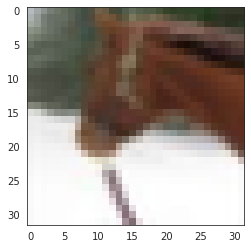

In [30]:
plt.imshow(x_test[0].reshape((32 ,32, 3)), vmin=0, vmax=1)

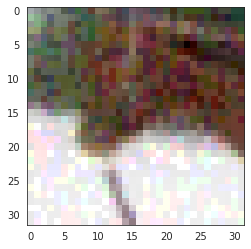

In [31]:
plt.imshow(adv_x_FGSM[0].reshape((32, 32, 3)), vmin=0, vmax=1)

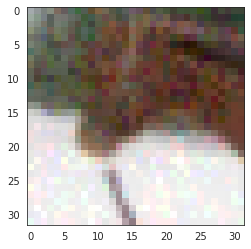

In [32]:
plt.imshow(adv_x_PGD_10[0].reshape((32, 32, 3)), vmin=0, vmax=1)

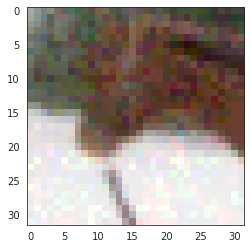

In [33]:
plt.imshow(adv_x_PGD_100[0].reshape((32, 32, 3)), vmin=0, vmax=1)

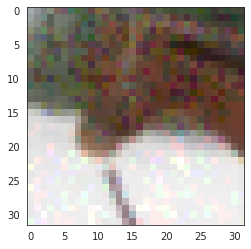

In [59]:
plt.imshow(adv_x_PGD_1000[0].reshape((32, 32, 3)), vmin=0, vmax=1)

In [34]:
t = None
c = np.zeros((1, train_size)) + 0.00387526
update_c_list = [1, 2, 4, 8, 16, 32, 64]
loss_type = ['cross-entropy', 'mse']

x_test_list = []
c_list = []
    

# Clean    
evaluate(x_train, x_test, model_fn=model_fn, kernel_fn=kernel_list[1], t=t, c=0, attack_type='Clean')
x_test_list.append(x_test)
c_list.append(c)


# FGSM
adv_x, c = fast_gradient_method(model_fn=model_fn, kernel_fn=kernel_list[1], obj_fn='test_c', 
                                grads_fn=test_col_wise_grads_fn, grads_c_fn=test_col_wise_c_grads_fn,
                                x_train=x_train, y_train=y_train, x_test=x_test, y=y_test, t=t, c=c,
                                loss=loss_type[0], eps=eps, clip_min=0, clip_max=1)

evaluate(x_train, adv_x, model_fn=model_fn, kernel_fn=kernel_list[1], t=t, c=c, attack_type='FGSM')
x_test_list.append(adv_x)
c_list.append(c)

for update_c in update_c_list:
    # PGD 10
    print('update_c:', update_c)
    key, new_key = random.split(key)
    c = np.zeros((1, train_size)) + 0.00387526
    adv_x, c = projected_gradient_descent(model_fn=model_fn, kernel_fn=kernel_list[1], obj_fn='test_c', 
                                          grads_fn=test_col_wise_grads_fn, grads_c_fn=test_col_wise_c_grads_fn,
                                          x_train=x_train, y_train=y_train, x_test=x_test, y=y_test, t=t, c=c, update_c=update_c, 
                                          loss=loss_type[0], eps=eps, eps_iter=eps_iter_10, nb_iter=10, 
                                          clip_min=0, clip_max=1, rand_init=None, rand_minmax=eps)
    
    evaluate(x_train, adv_x, model_fn=model_fn, kernel_fn=kernel_list[1], t=t, c=c, attack_type='PGD-10')
    x_test_list.append(adv_x)
    c_list.append(c)

for update_c in update_c_list:
    # PGD 100
    print('update_c:', update_c)
    key, new_key = random.split(key)
    c = np.zeros((1, train_size)) + 0.00387526
    adv_x, c = projected_gradient_descent(model_fn=model_fn, kernel_fn=kernel_list[1], obj_fn='test_c', 
                                          grads_fn=test_col_wise_grads_fn, grads_c_fn=test_col_wise_c_grads_fn,
                                          x_train=x_train, y_train=y_train, x_test=x_test, y=y_test, t=t, c=c, update_c=update_c, 
                                          loss=loss_type[0], eps=eps, eps_iter=eps_iter_100, nb_iter=100, 
                                          clip_min=0, clip_max=1, rand_init=None, rand_minmax=eps)
    
    evaluate(x_train, adv_x, model_fn=model_fn, kernel_fn=kernel_list[1], t=t, c=c, attack_type='PGD-100')
    x_test_list.append(adv_x)
    c_list.append(c)

NameError: name 'kernel_list' is not defined